In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

sns.set(context='notebook', style='white', font_scale=1.2)

In [3]:
try:
    import crossmapy as cmp
except:
    import sys
    sys.path.append('../')
    import crossmapy as cmp

In [4]:
def count_mapping(map_x2y, tgt_neighbor):
    return len(np.where(map_x2y < tgt_neighbor)[-1])

In [5]:
def cross_mapping_cardinality(Xt, Yt, embed_dim, n_neighbor=None):
    if n_neighbor is None:
        n_neighbor = embed_dim + 1

    idx = cmp.sorted_distance_index(Xt, embed_dim)
    idy = cmp.sorted_distance_index(Yt, embed_dim)
    n_row = len(idx)

    map_x2y = np.array([np.where(idx[t][1:] == idy[t][1:n_neighbor + 1, None])[-1] for t in range(n_row)])
    map_y2x = np.array([np.where(idy[t][1:] == idx[t][1:n_neighbor + 1, None])[-1] for t in range(n_row)])

    n_ele = map_x2y.size
    x2y_ratios = [count_mapping(map_x2y, i) / n_ele for i in range(n_row)]
    y2x_ratios = [count_mapping(map_y2x, i) / n_ele for i in range(n_row)]
    return x2y_ratios, y2x_ratios

In [7]:
ntrails = 1
n_iter = 5000
seed = 0
Bxy = 0.
Byx = 0.2
noise = 0.005
XY = cmp.mul_logistic_2v(b_yx=Byx, b_xy=Bxy, seed=seed, n_iter=n_iter, n_trail=ntrails, noise=noise)

In [9]:
np.random.seed(seed)
starts = np.random.choice(range(4000), 10, replace=False)

embed_dim = 2
x2y_list = []
y2x_list = []
for start in starts:
    end = start + 1000
    Xt = XY[0, start + 1:end + 1, 0]
    Yt = XY[0, start + 1:end + 1, 1]

    x2y_ratios, y2x_ratios = cross_mapping_cardinality(Xt, Yt, embed_dim=embed_dim)
    x2y_list.append(x2y_ratios)
    y2x_list.append(y2x_ratios)
x2y_avg = np.mean(x2y_list, axis=0)
y2x_avg = np.mean(y2x_list, axis=0)

In [10]:
def plot_mul_roc_curve(ratios_list, colors=None, labels=None, diag_line=True,
                       legend_loc=None, grid=True, title=None, tight_layout=True, **kwargs):
    n_curve = len(ratios_list)
    fig, ax = plt.subplots(figsize=(5, 5))

    for i in range(n_curve):
        ratios = ratios_list[i]
        n_ele = len(ratios)
        neighbor_ratios = np.arange(n_ele) / (n_ele - 1)
        auc = metrics.auc(neighbor_ratios, ratios)
        if labels is None:
            label = f'AUC{i+1}({auc:.3f})'
        else:
            label = f'{labels[i]}={auc:.3f}'
        if colors is None:
            ax.plot(neighbor_ratios, ratios, label=label, **kwargs)
        else:
            ax.plot(neighbor_ratios, ratios, color=colors[i], label=label, **kwargs)

    if diag_line:
        ax.plot([0, 1], [0, 1], ls='--', c='grey')

    ax.set_xlabel('Normalized $r$')
    ax.set_ylabel('Normalized $card$')

    if title is not None:
        ax.set_title(title)

    if legend_loc is None:
        loc = 'lower right'
    else:
        loc = legend_loc

    if grid:
        ax.grid()

    ax.legend(loc=loc)
    # ax.axis('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if tight_layout:
        fig.tight_layout()
    return fig, ax

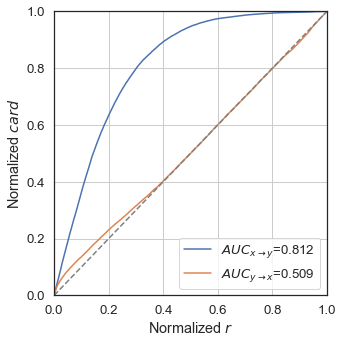

In [11]:
fig, ax = plot_mul_roc_curve([x2y_avg, y2x_avg], labels=[r'$AUC_{x\rightarrow y}$', r'$AUC_{y\rightarrow x}$'])

In [13]:
x2y_aucs = []
y2x_aucs = []
for Byx in tqdm(np.arange(0.01, 0.41, 0.01)):
    XY = cmp.mul_logistic_2v(b_yx=Byx, b_xy=Bxy, seed=seed, n_iter=n_iter,
                             n_trail=ntrails, noise=noise)

    np.random.seed(seed)
    starts = np.random.choice(range(4000), 10, replace=False)

    x2y_list = []
    y2x_list = []
    for start in starts:
        end = start + 1000
        Xt = XY[0, start + 1:end + 1, 0]
        Yt = XY[0, start + 1:end + 1, 1]

        x2y_ratios, y2x_ratios = cross_mapping_cardinality(Xt, Yt, embed_dim=embed_dim)
        x2y_list.append(x2y_ratios)
        y2x_list.append(y2x_ratios)
    x2y_avg = np.mean(x2y_list, axis=0)
    y2x_avg = np.mean(y2x_list, axis=0)

    n_ele = len(x2y_avg)
    neighbor_ratios = np.arange(n_ele) / (n_ele - 1)
    x2y_auc = metrics.auc(neighbor_ratios, x2y_avg)
    y2x_auc = metrics.auc(neighbor_ratios, y2x_avg)
    x2y_aucs.append(x2y_auc)
    y2x_aucs.append(y2x_auc)

In [14]:
def auc_to_score(aucs):
    dat = np.array(aucs)
    dat[dat < 0.5] = 0.5
    scores = 2 * (dat - .5)
    return scores

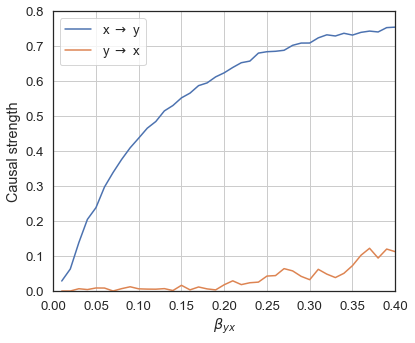

In [16]:
byxs = np.arange(0.01, 0.41, 0.01)

fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(byxs, auc_to_score(x2y_aucs), label=r'x $\rightarrow$ y')
plt.plot(byxs, auc_to_score(y2x_aucs), label=r'y $\rightarrow$ x')
plt.legend()
plt.grid()
plt.xlim(0, 0.4)
plt.ylim(0, 0.8)
plt.xlabel(r'$\beta_{yx}$')
plt.ylabel('Causal strength')
plt.tight_layout()